In [1]:
 ## Set max width in Jupyter notebook
from IPython.core.display import display, HTML
import pandas as pd
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option("display.max_columns", None)

C:\Users\eaghmey\AppData\Local\Temp\ipykernel_35196\2557818281.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Author: Meysam Aghighi
# Contact: meysam.aghighi@gmail.com
# Date: 2023-10-09
# Description: Time series prediction Kaggle contest

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, SimpleRNN, Dense
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge

In [5]:
## Read input data
holiday_events_df = pd.read_csv('data/holidays_events.csv')
oil_df = pd.read_csv('data/oil.csv')
sample_submission_df = pd.read_csv('data/sample_submission.csv')
stores_df = pd.read_csv('data/stores.csv')
test_df = pd.read_csv('data/test.csv')
train_df = pd.read_csv('data/train.csv')
transactions_df = pd.read_csv('data/transactions.csv')

#### Step 1: Data Preprocessing
Load and preprocess the dataset. This includes handling missing values, encoding categorical variables ('family' and 'onpromotion'), and sorting by date.

In [43]:
# Handle missing values if any
train_df.fillna(0, inplace=True)  # Replace missing values with 0, or use another strategy

# Preprocess the 'date' column
train_df['date'] = pd.to_datetime(train_df['date'])
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['day_of_week'] = train_df['date'].dt.dayofweek

# Encode categorical variables
train_df = pd.get_dummies(train_df, columns=['family'])

# Sort by data properly (by date or id)
# train_df['date'] = pd.to_datetime(train_df['date'])
# train_df = train_df.sort_values(by='date')
train_df = train_df.sort_values(by='id')

#### Step 2: Train-Validation Split
Split the dataset into training and validation sets, keeping the temporal order.

In [44]:
# Define the split point (e.g., 80% train, 20% validation)
split_point = int(0.2 * len(train_df))

# Split the data
train_data = train_df[:split_point]
validation_data = train_df[split_point:]

#### Step 3: Model Selection and Training
Choose a machine learning model for time series forecasting. In this example, we'll use XGBoost, which is a popular choice for such problems.

In [45]:
# Define the features and target variable
features = ['year', 'month', 'day', 'day_of_week', 'store_nbr'] + [col for col in train_df.columns if col.startswith('family_')] + ['onpromotion']

# Define the training data
X_train = train_data[features]
y_train = train_data['sales']

# Define the validation data
X_valid = validation_data[features]
y_valid = validation_data['sales']

#### Step 4: Training and Evaluation
Training and evaluation for many models.

In [ ]:
# Define a list of models
models = [
    ("Linear Regression", LinearRegression()),
    ("Random Forest", RandomForestRegressor(n_estimators=10, random_state=42)),
    ("SVR", SVR(kernel='rbf')),
    ("XGBoost", XGBRegressor(n_estimators=10, learning_rate=0.1, random_state=42)),
    ("LightGBM", LGBMRegressor(n_estimators=10, random_state=42)),
    ("CatBoost", CatBoostRegressor(iterations=10, random_state=42, verbose=0)),
    # ARIMA and SARIMA models will be handled separately.
    # LSTM, CNN and RNN models will be handled separately.
    ("Gradient Boosting", GradientBoostingRegressor(n_estimators=10, random_state=42)),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("MLP", MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)),
    ("Bayesian Ridge", BayesianRidge())
]

# Create a directory to store models and predictions
output_dir = 'trained_models_and_predictions'
os.makedirs(output_dir, exist_ok=True)

best_model = None
best_rmsle = float('inf')

# Train and evaluate the models
for model_name, model in models:
    start_time = time.time()
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    y_pred = [max(value, 0) for value in y_pred]
    
    rmsle = np.sqrt(mean_squared_log_error(y_valid, y_pred))
    
    training_time = time.time() - start_time
    print(f"{model_name} RMSLE: {rmsle:.2f} Time (s): {training_time:.2f}")
    
    # Save the model if it has the lowest RMSLE
    if rmsle < best_rmsle:
        best_model = model
        best_rmsle = rmsle
    
    # Save the predictions
    predictions_filename = f'{output_dir}/{model_name}_predictions.pkl'
    joblib.dump(y_pred, predictions_filename)

# Save the best model
best_model_filename = f'{output_dir}/best_model.pkl'
joblib.dump(best_model, best_model_filename)

Linear Regression RMSLE: 9.54 Time (s): 4.34
Random Forest RMSLE: 2.04 Time (s): 64.08


In [ ]:
# Handle ARIMA and SARIMA separately.
arima_model = ARIMA(y_train.values.astype('float32'), order=(5, 1, 0))
arima_model_fit = arima_model.fit(disp=0)
y_pred_arima = arima_model_fit.forecast(steps=len(X_valid))[0]
rmsle_arima = np.sqrt(mean_squared_log_error(y_valid.values.astype('float32'), y_pred_arima))
print(f"ARIMA RMSLE: {rmsle_arima:.2f}")

sarima_model = SARIMAX(y_train.values.astype('float32'), order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model_fit = sarima_model.fit(disp=0)
y_pred_sarima = sarima_model_fit.forecast(steps=len(X_valid))[0]
rmsle_sarima = np.sqrt(mean_squared_log_error(y_valid.values.astype('float32'), y_pred_sarima))
print(f"SARIMA RMSLE: {rmsle_sarima:.2f}")

In [ ]:
# Handle LSTM, CNN and RNN separately.
X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_valid_reshaped = X_valid.values.reshape(X_valid.shape[0], X_valid.shape[1], 1)

lstm_model = Sequential([
        LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
        Dense(1)
])
lstm_model.compile(loss='mean_squared_log_error', optimizer='adam')
lstm_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=64)
y_pred_lstm = lstm_model.predict(X_valid_reshaped).flatten()
rmsle_lstm = np.sqrt(mean_squared_log_error(y_valid.values.astype('float32'), y_pred_lstm))
print(f"LSTM RMSLE: {rmsle_lstm:.2f}")

cnn_model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
        Dense(1)
])
cnn_model.compile(loss='mean_squared_log_error', optimizer='adam')
cnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=64)
y_pred_cnn = cnn_model.predict(X_valid_reshaped).flatten()
rmsle_cnn = np.sqrt(mean_squared_log_error(y_valid.values.astype('float32'), y_pred_cnn))
print(f"CNN RMSLE: {rmsle_cnn:.2f}")

rnn_model = Sequential([
        SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 1)),
        Dense(1)
])
rnn_model.compile(loss='mean_squared_log_error', optimizer='adam')
rnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=64)
y_pred_rnn = rnn_model.predict(X_valid_reshaped).flatten()
rmsle_rnn = np.sqrt(mean_squared_log_error(y_valid.values.astype('float32'), y_pred_rnn))
print(f"RNN RMSLE: {rmsle_rnn:.2f}")

#### Visualize comparison
Plot to compare the predicted and real sales values.

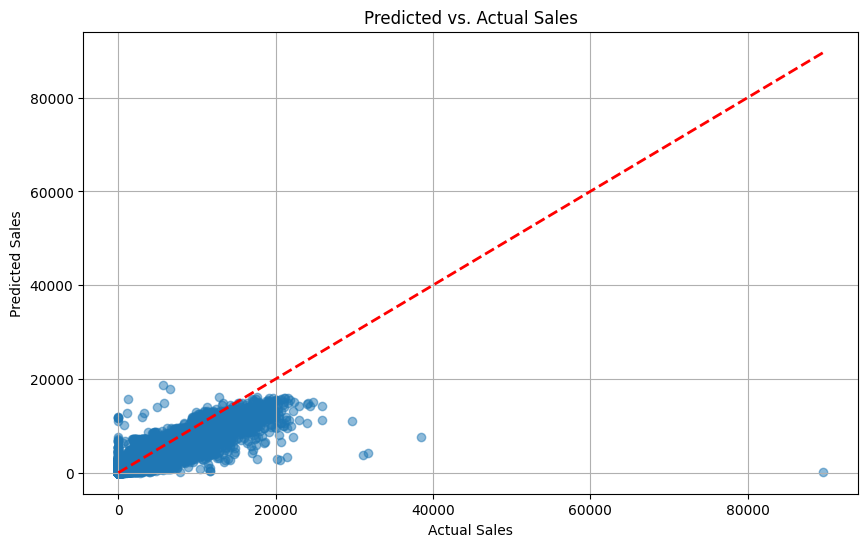

In [20]:
import matplotlib.pyplot as plt

# Assuming you already have 'y_pred' (predicted sales) and 'y_valid' (actual sales) calculated

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred, alpha=0.5)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Predicted vs. Actual Sales')
plt.grid(True)

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)], linestyle='--', color='red', linewidth=2)

plt.show()

In [24]:
X_train.shape

(2400710, 39)

In [26]:
type(y_train)

pandas.core.series.Series